<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and RF - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [3]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

In [4]:
bos = pd.DataFrame(boston.data, columns=boston.feature_names)
bos['MEDV'] = y

In [5]:
#do a quick check of the first few rows
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
#look at the dimensions of the dataset
bos.shape

(506, 14)

In [7]:
#examine total number of nulls and see that there are none (so no need to impute values)
bos.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [8]:
#examine the index
bos.index

RangeIndex(start=0, stop=506, step=1)

In [9]:
#examine the data types
bos.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

In [10]:
#we examine the summary statistics and see that that the variables are measured at different scales
#which means they will not contribute equally to the analysis
#we'll need to standardize data so that it is internally consistent
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [11]:
#examine the number of unique values in each column
bos.nunique()

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
MEDV       229
dtype: int64

In [12]:
import seaborn as sns

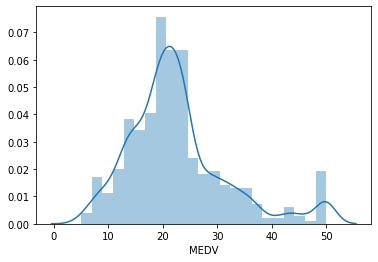

In [31]:
#histogram distribution of the target(median value)
sns.distplot(bos["MEDV"]);

#it looks like the target  deviates from normal distribution
#the target data also contains outliers
#should log transform the median values to improve predictions

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

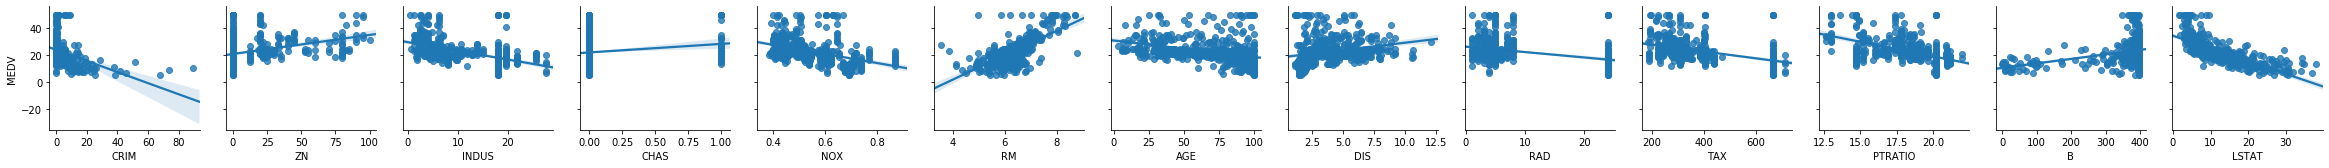

In [273]:
#built a pairplot in order to see the relationship between each variable and the target
sns.pairplot(bos, x_vars=["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS","RAD", "TAX", "PTRATIO", "B", "LSTAT"], y_vars=["MEDV"], kind='reg');

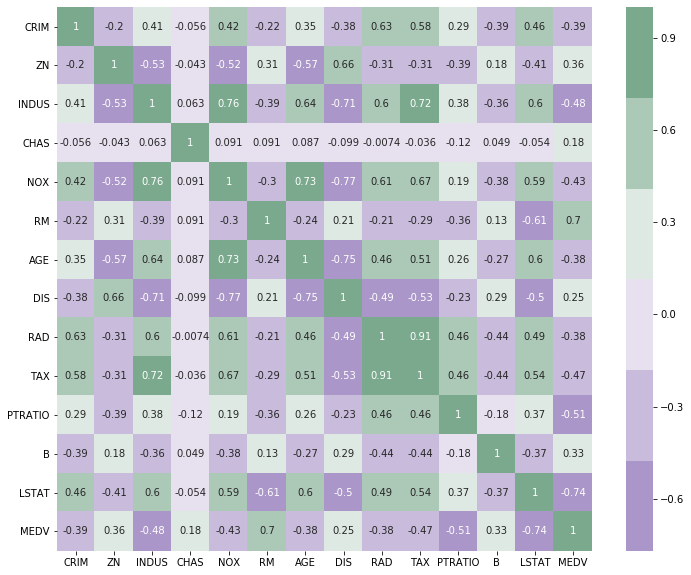

In [363]:
#expanded on the heatmap code so the correlation coefficient can be seen! 
# used --> https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
# and for the color palatte --> http://www.hsluv.org/

plt.figure(figsize=(12,10))
color = sns.diverging_palette(281.4, 144.7, s=41, l=65.5)
sns.heatmap(bos.corr(),annot=True, cmap = color);

In [274]:
#looked at the correlation with the target variable
bos.corr().abs().loc[:,"MEDV"].sort_values(ascending=False)

MEDV       1.000000
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: MEDV, dtype: float64

In [377]:
new_bos = pd.DataFrame(columns=["RM", "PTRATIO", "LSTAT","MEDV"])

for col in new_bos.columns:
    new_bos[col] = bos[col]    

In [378]:
new_bos.head()

,RM,PTRATIO,LSTAT,MEDV
0,6.575,15.3,4.98,24.0
1,6.421,17.8,9.14,21.6
2,7.185,17.8,4.03,34.7
3,6.998,18.7,2.94,33.4
4,7.147,18.7,5.33,36.2


In [379]:
#import and initialize the linear regression model
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()

In [380]:
#created my independent and dependent variables
X = new_bos.drop(columns = "MEDV")
y = new_bos["MEDV"]

In [381]:
#standardize the data
X = (X-X.mean())/X.std()

In [382]:
#I initially tried log+1 transforming the target but ran into issues when I inversed the predicted values so for now going 
#y = np.log1p(y)

In [383]:
#the mean is now as close as possible to zero and all variables have a standard deviation of 1
X.describe()

,RM,PTRATIO,LSTAT
count,5.060000e+02,5.060000e+02,5.060000e+02
mean,-1.149882e-14,-1.084420e-14,-6.494585e-16
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.876413e+00,-2.704703e+00,-1.529613e+00
25%,-5.680681e-01,-4.875567e-01,-7.986296e-01
50%,-1.083583e-01,2.745872e-01,-1.810744e-01
75%,4.822906e-01,8.057784e-01,6.024226e-01
max,3.551530e+00,1.637208e+00,3.545262e+00


In [384]:
lreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [385]:
lreg.coef_

array([ 3.17261216, -2.01496363, -4.08329959])

In [386]:
#another nicer way to look at the coefficients
coeffs = pd.DataFrame({
    "Variables": X.columns,
    "Weight": lreg.coef_
})

In [387]:
coeffs.sort_values(by="Weight")

,Variables,Weight
2,LSTAT,-4.083300
1,PTRATIO,-2.014964
0,RM,3.172612


In [388]:
#R squared examines the explained variance over total variance ... how much better than the most naive model is our model?
#But still need to look at residruals because r squared doesn't determine if the coeffs or predictions are biased
lreg.score(X,y)

0.678624160161311

In [391]:
#examine the residuals - build a column for the predicted observations of median value
new_bos['PREDICT'] = lreg.predict(X)

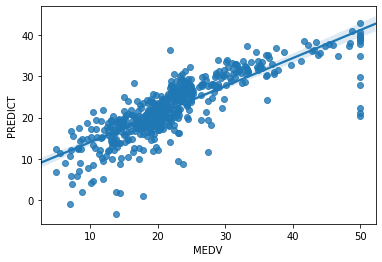

In [394]:
#plot observed median values and predicted median values
sns.regplot(x='MEDV', y ='PREDICT', data=new_bos);

In [396]:
#calculate the residuals of your model ('observed' - 'predicted')
new_bos['ERROR']=new_bos['MEDV']-new_bos['PREDICT']

In [397]:
#check that the mean is close to zero
new_bos['ERROR'].mean()

-5.241305852222478e-15

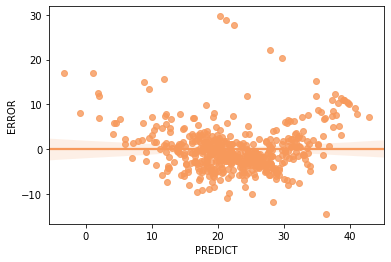

In [398]:
#residual plot is fairly symmetrical, tends to cluster in the middle of the plot
sns.regplot(x='PREDICT', y ='ERROR', data=new_bos, color = '#F7995B');

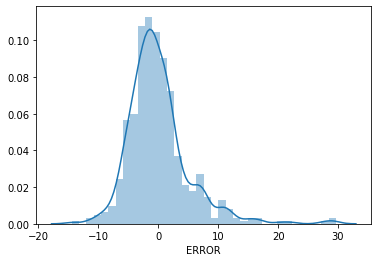

In [399]:
#check for normal distribution...
sns.distplot(new_bos['ERROR']);

In [400]:
#attempting regularization using Lasso
from sklearn.linear_model import Lasso

In [402]:
#built new X,y variables
X_2 = bos[["RM", "PTRATIO", "LSTAT"]]
y_2 = bos["MEDV"]

In [403]:
#standardized X
X_2 = (X_2-X_2.mean())/X_2.std()

In [404]:
#initialized Lasso
lasso = Lasso()

In [405]:
#Fit the model 
lasso.fit(X_2,y_2)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [406]:
lasso.coef_

array([ 2.68466746, -1.3572336 , -3.62684407])

In [407]:
lasso.score(X_2,y_2)

0.6596465679100378

In [233]:
#rather than adding a new column, created a new variable
y_predict_2 = lasso.predict(X_2)

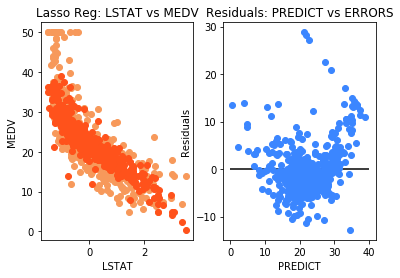

In [423]:
#attempting a second way to display the relationship between LSTAT and median value
plt.subplot(1, 2, 1)
plt.title("Lasso Reg: LSTAT vs MEDV")
plt.xlabel("LSTAT")
plt.ylabel("MEDV")
plt.plot(X_2.LSTAT, y_2, 'o', color = '#F7995B')
plt.plot(X_2.LSTAT, y_predict_2, 'o', color = '#FF521B')


#residulas compiled by subtracting predicted values from observed values 
plt.subplot(1, 2, 2)
plt.title("Residuals: PREDICT vs ERRORS")
plt.xlabel("PREDICT")
plt.ylabel("Residuals")
plt.plot(y_predict_2, y_2 - y_predict_2, 'o', color ='#3B86FF')
plt.hlines(y=0,xmin=0, xmax=40, colors='k', linestyles='solid')
plt.show()


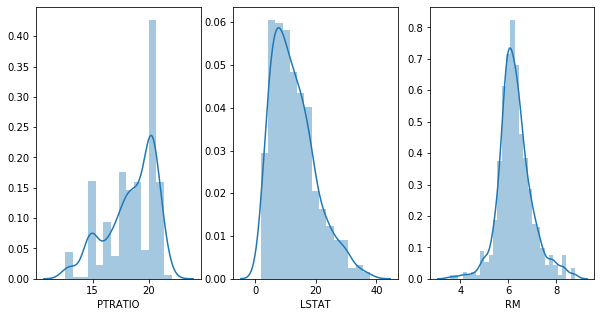

In [48]:
# contemplating log transforming the independent variables
f, axes = plt.subplots(1, 3, figsize=(10, 5))
                    
sns.distplot(bos["PTRATIO"], ax=axes[0])
sns.distplot(bos["LSTAT"], ax=axes[1])
sns.distplot(bos["RM"], ax=axes[2]);

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [424]:
from sklearn.model_selection import train_test_split

In [425]:
X = bos[['LSTAT','RM', 'PTRATIO']]
y = new_bos["MEDV"]

In [426]:
X = (X-X.mean())/X.std()

In [427]:
#Create train and test splits with 30% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019, test_size=0.3)

In [428]:
#Train linear regression model on the train data
lreg = LinearRegression()
lreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [429]:
y_predict = lreg.predict(X_test)
r2_train_30 = lreg.score(X_test,y_test)

In [430]:
r2_train_30

0.6383960920788283

In [431]:
#Updated sample size to 10%
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019, test_size=0.1)

lreg = LinearRegression()
lreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [432]:
#Print the r squared and summary stats for this model
y_predict = lreg.predict(X_test)
r2_train10 = lreg.score(X_test,y_test)
r2_train10

0.648215647083749

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [433]:
from sklearn.model_selection import cross_val_score

In [434]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2019)

In [435]:
#create a list with the looping number of folds
num_folds = [5,6,7,8,9,10]
fold_scores=[]

In [436]:
#run through the folds as you perform cross-validation
for fold in num_folds:
    model = LinearRegression()
    scores = cross_val_score(model, X=X_train, y=y_train, cv=fold)
    fold_scores.append((fold,np.mean(scores),np.std(scores))) 
    

In [437]:
fold_scores

[(5, 0.6793701207970567, 0.09428068079616873),
 (6, 0.6582607321248553, 0.07060270360376461),
 (7, 0.6740232004052557, 0.10456556475158395),
 (8, 0.6717561734704662, 0.12210036887999806),
 (9, 0.6722600476253842, 0.09966449705971048),
 (10, 0.6755789078183676, 0.11092124509268601)]

In [438]:
#the above wasn't super digestible, so making it a little more format friendly below: 
for fold in num_folds:
    print('\n')
    print("k fold: ",fold)
    model = LinearRegression()
    
    scores = cross_val_score(model, X_train, y_train, cv=fold)
    print("mean cv:", np.mean(scores))
    print("std cv:", np.std(scores))



k fold:  5
mean cv: 0.6793701207970567
std cv: 0.09428068079616873


k fold:  6
mean cv: 0.6582607321248553
std cv: 0.07060270360376461


k fold:  7
mean cv: 0.6740232004052557
std cv: 0.10456556475158395


k fold:  8
mean cv: 0.6717561734704662
std cv: 0.12210036887999806


k fold:  9
mean cv: 0.6722600476253842
std cv: 0.09966449705971048


k fold:  10
mean cv: 0.6755789078183676
std cv: 0.11092124509268601


## Using Random Forests With the Boston Dataset

#### Create X and y variables for Your Data

In [441]:
#import and initialize RF
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [442]:
#create the X and y variables
X = bos.iloc[:,:-1]
y = bos['MEDV']
#y = np.log1p(y)

#### Divide it into a training and test set

In [443]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019, test_size=0.3)

#### Fit a Random Forest on the data

In [444]:
rf.fit(X_train, y_train);

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### What are its most important features?

In [445]:
#It looks like LSTAT (unsurprising), Rooms and Crime Rate are the most important features
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance'])

feature_importances.sort_values('importance', ascending=False)

,importance
RM,0.492903
LSTAT,0.333191
DIS,0.084821
CRIM,0.027868
TAX,0.016174
AGE,0.011488
PTRATIO,0.009688
B,0.008312
NOX,0.007865
INDUS,0.002675


#### How well does your model perform on your test set?

In [446]:
#better than the linear models though we only looked at 4 variables with the linear model
rf.score(X_test, y_test)

0.8228148258947743

#### Challenge:  Try and find at least two improvements to your model to improve test scores.

You can try the following:
 - increasing the number of trees
 - using a different number of maximum features to sample
 - using a different number of minimum samples per leaf

In [447]:
#increase number of trees
num_trees = [1, 10, 25, 50, 100, 1000]

for tree in num_trees:
    print("\n")
    print("number trees: ", tree)
    #set the parameter 
    rf.set_params(n_estimators = tree)
    scores = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10)
    print("rf scores: ", np.mean(scores))




number trees:  1
rf scores:  0.7565437971125524


number trees:  10
rf scores:  0.8572427664796969


number trees:  25
rf scores:  0.8667684930623327


number trees:  50
rf scores:  0.8657786654383953


number trees:  100
rf scores:  0.8769379390981727


number trees:  1000
rf scores:  0.871519062974507


In [449]:
#leverage a different number of max features to sample
#when splitting a node, this is the size of the random subsets of features to consider 
max_feat = [1, 0.5, 'sqrt', 'log2']

for feat in max_feat:
    print("\n")
    print("max feat: ", feat)
     #set the parameter 
    rf.set_params(max_features = feat)
    scores = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10)
    print("rf scores: ", np.mean(scores))



max feat:  1
rf scores:  0.8126808166670539


max feat:  0.5
rf scores:  0.8741304332027369


max feat:  sqrt
rf scores:  0.860703973696068


max feat:  log2
rf scores:  0.860421705842209


In [450]:
#calibrate the min number of data points allowed in a leaf node
samples = [1, 2, 4, 8]

for samp in samples:
    print("\n")
    print("min samp: ", samp)
     #set the parameter 
    rf.set_params(min_samples_leaf = samp)
    scores = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10)
    print("rf scores: ", np.mean(scores))



min samp:  1
rf scores:  0.8587785054771226


min samp:  2
rf scores:  0.847964218790396


min samp:  4
rf scores:  0.8187946498931483


min samp:  8
rf scores:  0.7788517631426543


In [451]:
#putting it all together, what is the best combination, also used trick so all CPUs are used

rf_scores = []

samples = [1, 2, 4, 8]
max_feat = [1, 0.5, 'sqrt', 'log2']
num_trees = [1, 10, 25, 50, 100, 1000]

for tree in num_trees:
    for feat in max_feat:
        for samp in samples:
            rf.set_params(n_estimators = tree,
                          max_features = feat, 
                          min_samples_leaf = samp,
                          n_jobs = -1)
            scores = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10)
            rf_scores.append((np.mean(scores), tree, feat, samp))

In [452]:
#find the max score from the list of potential combinations
max(rf_scores)

(0.8715417887248222, 1000, 0.5, 1)

In [453]:
#adjust model accordingly and it's a bit higher! 
rf.set_params(n_estimators = 50,
              max_features = 0.5, 
              min_samples_leaf = 1)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8660541931503127

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [454]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [455]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              1221.
Date:                Mon, 16 Dec 2019   Prob (F-statistic):                   1.38e-321
Time:                        16:39:17   Log-Likelihood:                         -1567.5
No. Observations:                 506   AIC:                                      3151.
Df Residuals:                     498   BIC:                                      3185.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9729      0.224     22.195      0.000       4.533       5.413
LSTAT         -0.5606      0.048    -11.795      0.000      -0.654      -0.467
RAD            0.2128      0.070      3.050      0.002       0.076       0.350
TAX           -0.0174      0.004     -4.272      0.000      -0.025      -0.009
NOX            4.3448      3.384      1.284      0.200      -2.304      10.994
INDUS          0.0924      0.067      1.383      0.167      -0.039       0.224
CRIM          -0.0891      0.037     -2.423      0.016      -0.161      -0.017
ZN             0.0288      0.013      2.220      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.139   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              832.155
Skew:                           1.666   Prob(JB):                    1.99e-181
Kurtosis:                       8.326   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [11]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [12]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [13]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.5043486813354807
